In [2]:
import sys
print(sys.executable)
!{sys.executable} -m pip install pandas


/home/examples/SUSY_kernel/bin/python

[notice] A new release of pip is available: 24.0 -> 24.3.1
[notice] To update, run: python -m pip install --upgrade pip


In [26]:
import uproot
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os #for looping over files in a directory
import math
import pandas as pd
from matplotlib.ticker import ScalarFormatter

In [4]:


base_path = "/data/users/mhance/photons/NTUP_ZLLG"
sub_dirs = ["mc16a_13TeV", "mc16d_13TeV", "mc16e_13TeV"]
sub_sub_dir = "00-03-01"

variables_to_extract = [
    'ph.loose_id', 'ph.pt', 'ph.eta', 'ph.truth_pt', 'ph.truth_pdgId',
    'ph.truth_status', 'ph.truth_origin', 'ph.truth_type', 'mc_weight.gen', 
    'ph.topoetcone30', 'ph.tight_AOD', 'ph.isEM_tight_AOD', 'ph.isEM_tight_id_incl'
]

combined_data = []

# Iterate over subdirectories and files
for sub_dir in sub_dirs:
    filespath = os.path.join(base_path, sub_dir, sub_sub_dir)
    for root, _, files in os.walk(filespath):
        for file in files:
            if file.endswith('.root') and "Powheg" in file:
                filepath = os.path.join(root, file)
                with uproot.open(filepath) as f:
                    if 'output;1' in f:
                        tree = f['output;1']
                        # Extract the data
                        data = tree.arrays(variables_to_extract, library="np")

                        # Apply the mask
                        total_mask = (
                            (data['ph.loose_id'] == True) & 
                            (data['ph.pt'] > 10000) & 
                            (abs(data['ph.eta']) < 2.37) & 
                            ((abs(data['ph.eta']) < 1.37) | (abs(data['ph.eta']) > 1.52))
                        )

                        # Filter and store data only for masked events
                        filtered_data = {var: data[var][total_mask] for var in variables_to_extract if var != 'ph.loose_id'}
                        
                        # Combine filtered data into a structured array
                        dtype = [(var, data[var].dtype) for var in filtered_data.keys()]
                        filtered_array = np.empty(len(filtered_data['ph.pt']), dtype=dtype)
                        
                        for var in filtered_data:
                            filtered_array[var] = filtered_data[var]
                        
                        # Append the structured array to the combined data list
                        combined_data.append(filtered_array)


In [5]:
if combined_data:
    combined_data = np.concatenate(combined_data)

# Applying masks based on the new combined data
realMask = (combined_data['ph.truth_pdgId'] == 22) & (combined_data['ph.truth_pt'] > 0) & (combined_data['ph.truth_type'] != 16) 
fakeMask = (combined_data['ph.truth_pdgId'] != 22) | (combined_data['ph.truth_type'] == 16)

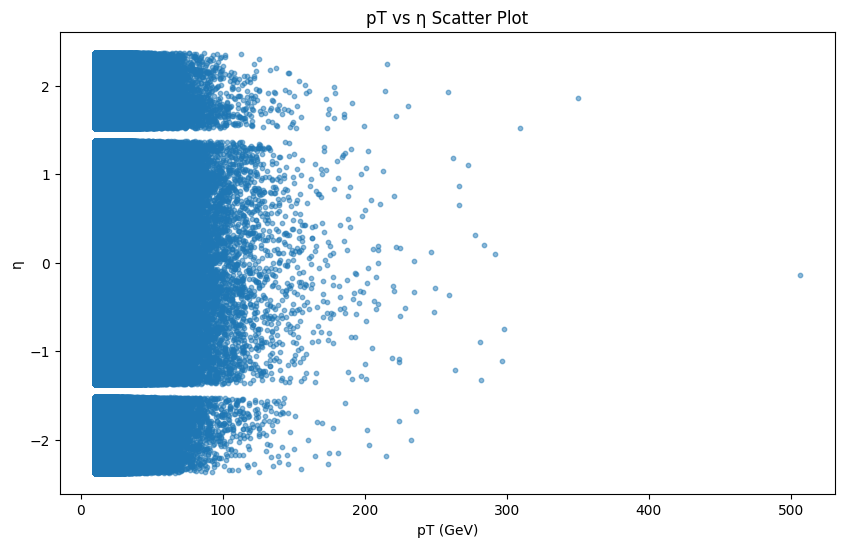

In [32]:

plt.figure(figsize=(10, 6))
plt.scatter(combined_data['ph.pt']/1000, combined_data['ph.eta'], alpha=0.5, s=10)  # Adjust alpha and marker size as needed

# Add labels and title
plt.title('pT vs η Scatter Plot')
plt.xlabel('pT (GeV)')
plt.ylabel('η')

# Show the plot
plt.show()

In [7]:
A = np.sum((combined_data['ph.tight_AOD'] == True) & (combined_data['ph.topoetcone30'] > 5000))
B = np.sum((combined_data['ph.tight_AOD'] != True) & (combined_data['ph.topoetcone30'] > 5000)) #only checked that not tight bc combined data should have only loose
C = np.sum((combined_data['ph.tight_AOD'] == True) & (combined_data['ph.topoetcone30'] < 5000))
D = np.sum((combined_data['ph.tight_AOD'] != True) & (combined_data['ph.topoetcone30'] < 5000))

print(f"(A) tight & !Iso = {A} ")
print(f"(B) !tight & !Iso = {B} ") 
print(f"(C) tight & Iso = {C} ") 
print(f"(D) !tight & Iso = {D} ") 

C_fake = (A*D) / B
print(f"C_fake = {C_fake} ") 

targetRatio = 1 - (C_fake/C)
print(f"C_real/C = {targetRatio} ") 
print()

uncertainty = math.sqrt( (1/A) + (1/B) + (1/D) ) * C_fake

print(f"N_Cfake : {C_fake} +/- {uncertainty}" )

N_Cfake = C_fake + (uncertainty/2)

purity = 1-(N_Cfake/C)

purity_range = (uncertainty/C_fake)
print(f"purity = {purity} +/- {purity_range}")

(A) tight & !Iso = 481840 
(B) !tight & !Iso = 1191852 
(C) tight & Iso = 3522481 
(D) !tight & Iso = 3605188 
C_fake = 1457499.5770615814 
C_real/C = 0.5862292579969682 

N_Cfake : 1457499.5770615814 +/- 2603.9061531093303
purity = 0.5858596454776801 +/- 0.0017865570557207178


In [8]:
actualReal = np.sum((combined_data['ph.tight_AOD'] == True) & (combined_data['ph.topoetcone30'] < 5000) & realMask)
actualFake = np.sum((combined_data['ph.tight_AOD'] == True) & (combined_data['ph.topoetcone30'] < 5000) & fakeMask)
print(f"C real : {actualReal} ")
print(f"C fake : {actualFake} ")
actualRatio = actualReal/C
print(f"C_real/C = {actualRatio} ") 


C real : 2613703 
C fake : 908778 
C_real/C = 0.7420062734192179 


In [9]:
pt_bins = np.array([10000, 15000, 20000, 25000, np.inf])  # np.inf handles 25+
eta_bins = np.array([0, 0.7, 1.37, 1.52, 2.0, 2.37])

pt_indices = np.digitize(combined_data['ph.pt'], pt_bins) - 1
eta_indices = np.digitize(combined_data['ph.eta'], eta_bins) - 1



N_Cfake : 107062.63637987497 +/- 792.3048387240945
purity = 0.6618857685869366 +/- 0.007400386031153511
__________________________

N_Cfake : 117132.78796657958 +/- 1112.154732231456
purity = 0.5758195518735076 +/- 0.009494819952110906
__________________________



/tmp/ipykernel_3941132/3080741290.py:41: RuntimeWarning: invalid value encountered in scalar divide
  C_fake = (A*D) / B
/tmp/ipykernel_3941132/3080741290.py:50: RuntimeWarning: invalid value encountered in scalar divide
  actual_values.append(realReal / C)
/tmp/ipykernel_3941132/3080741290.py:52: RuntimeWarning: divide by zero encountered in scalar divide
  uncertainty = math.sqrt( (1/A) + (1/B) + (1/D) ) * C_fake
/tmp/ipykernel_3941132/3080741290.py:73: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  ax.set_yscale('log')


N_Cfake : nan +/- nan
purity = nan +/- nan
__________________________

N_Cfake : 45506.70476941269 +/- 653.7591348336513
purity = 0.6136588330861086 +/- 0.014366215663083458
__________________________

N_Cfake : 21126.8237131806 +/- 439.050352356296
purity = 0.6481680365018666 +/- 0.020781654559950784
__________________________

N_Cfake : 25272.36079703899 +/- 351.01297488101295
purity = 0.8524051150148797 +/- 0.013889204008283192
__________________________

N_Cfake : 28418.361388742767 +/- 486.2247008176488
purity = 0.7959790598211058 +/- 0.017109526273047352
__________________________

N_Cfake : nan +/- nan
purity = nan +/- nan
__________________________

N_Cfake : 10536.627054642382 +/- 281.0285063950903
purity = 0.8388963967130905 +/- 0.02667158142142562
__________________________

N_Cfake : 4386.015301530153 +/- 171.04170684389732
purity = 0.8678780240233985 +/- 0.038997061132966374
__________________________

N_Cfake : 7581.446182943604 +/- 194.43464736211092
purity = 0.926356470

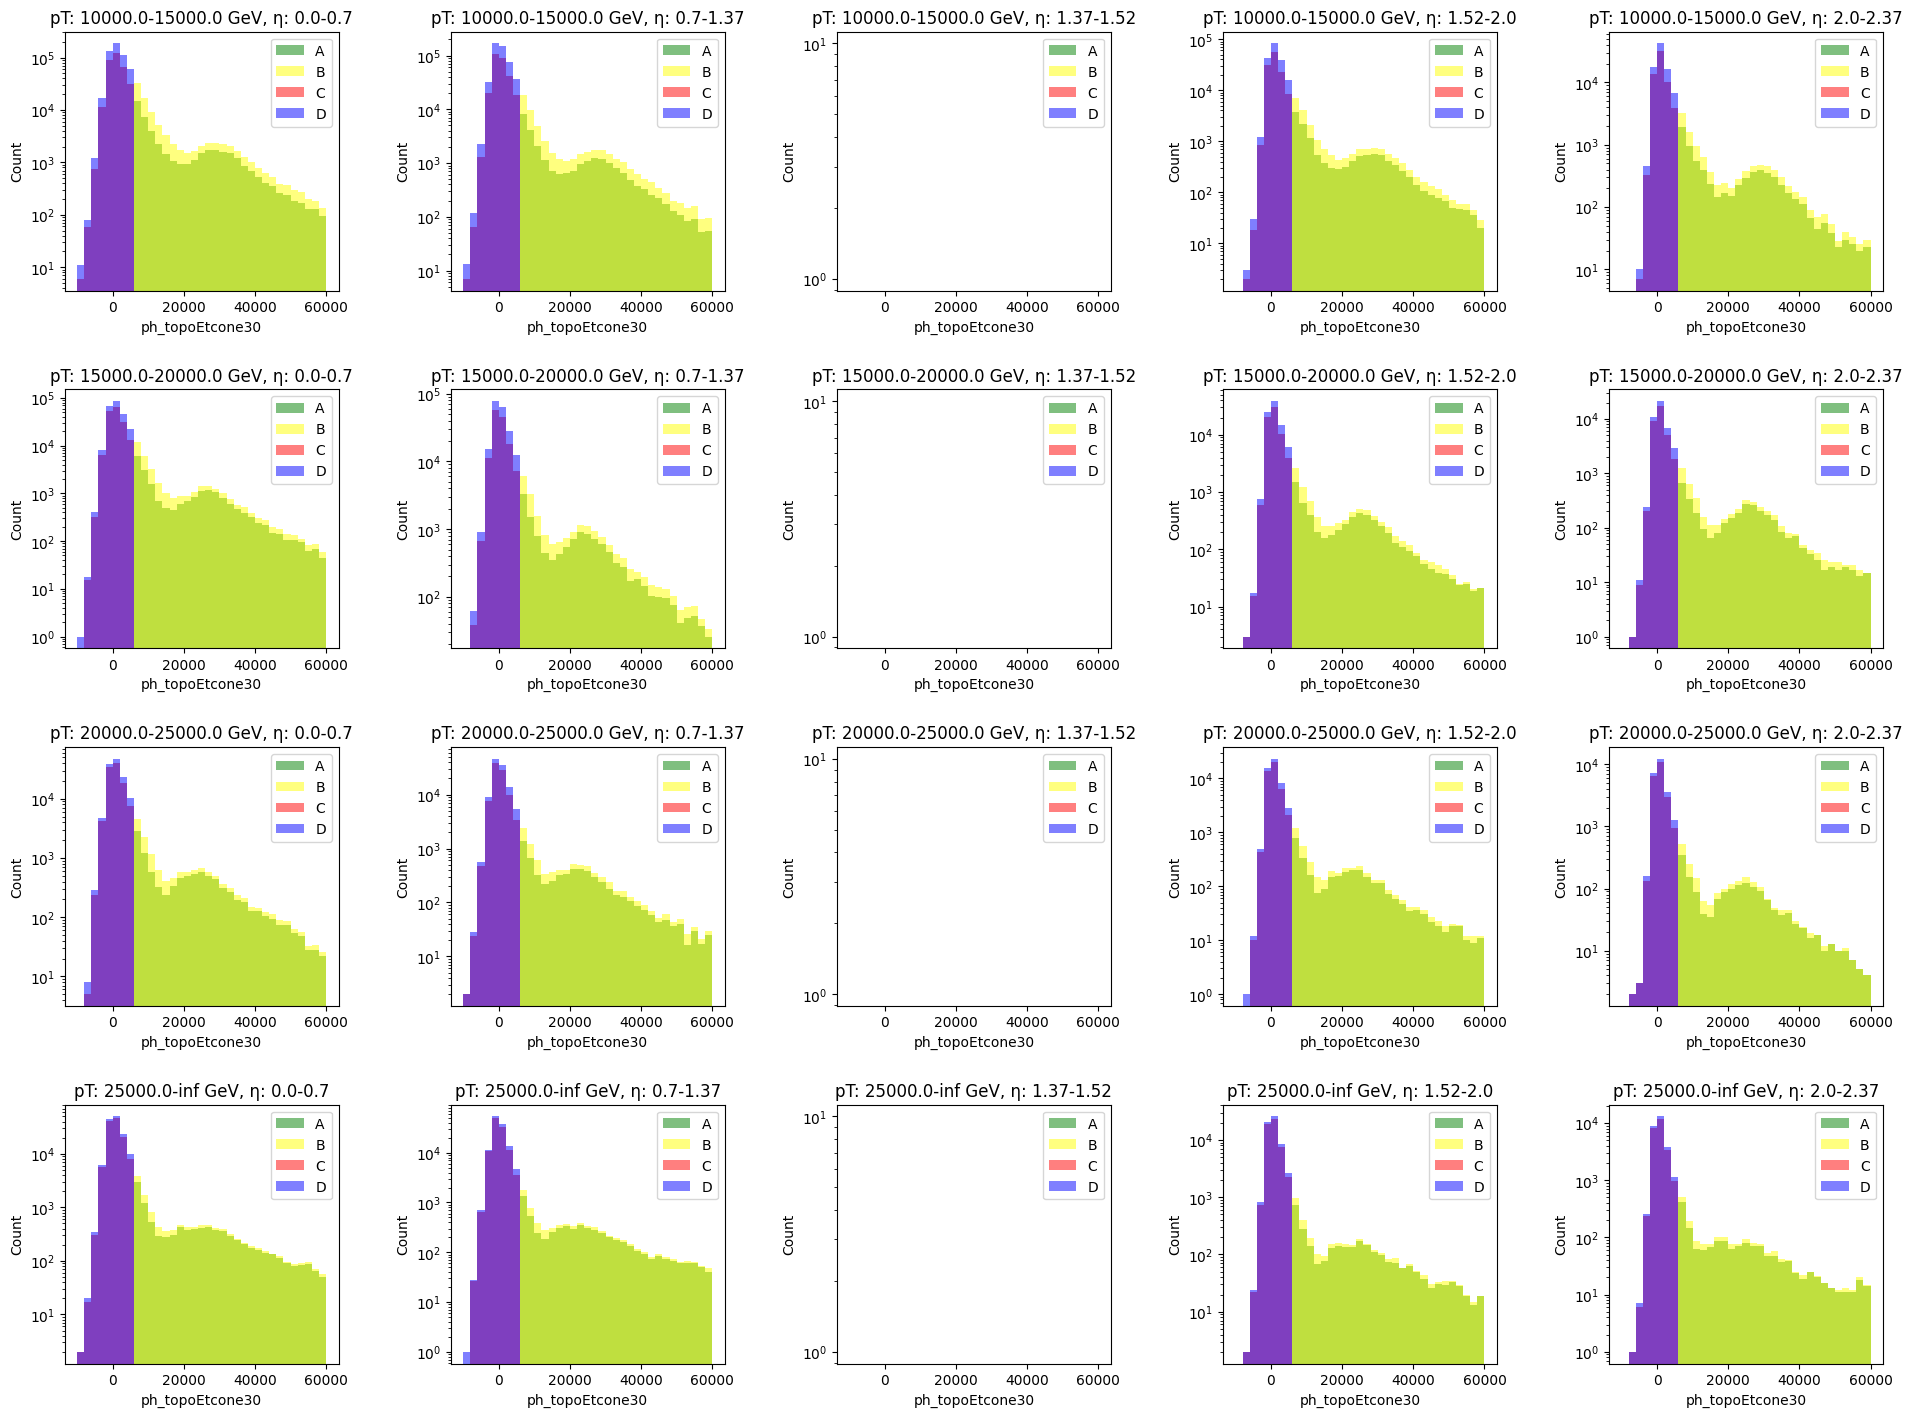

In [12]:
fig, axes = plt.subplots(len(pt_bins) - 1, len(eta_bins) - 1, figsize=(20, 15))
fig.tight_layout(pad=5.0)


#tightMask = (combined_data['ph.tight_AOD'] == True) 
#notTightMask = (combined_data['ph.tight_AOD'] != True) 
tightMask = (combined_data['ph.isEM_tight_id_incl'] == 0)
notTightMask = ( (combined_data['ph.isEM_tight_id_incl'] & 0x45fc01) == 0 )

isolation_val = 6000
isolation_values = [2000, 4000, 6000, 8000]

notIsolatedMask = (combined_data['ph.topoetcone30'] > isolation_val)
isolatedMask = (combined_data['ph.topoetcone30'] < isolation_val)

bins = []
calculated_values = []
actual_values = []

for i in range(len(pt_bins) - 1):
    for j in range(len(eta_bins) - 1):
        ax = axes[i][j] if axes.ndim > 1 else axes[max(i, j)]
        
        # Mask for current pt and eta bin
        bin_mask = (pt_indices == i) & (eta_indices == j)
        
        # Plot ph_topoEtcone30 for real and fake photons
        ax.hist(combined_data['ph.topoetcone30'][bin_mask & tightMask & notIsolatedMask], range = (-10000,60000), bins=35, alpha=0.5, label='A', color='green')
        ax.hist(combined_data['ph.topoetcone30'][bin_mask & notTightMask & notIsolatedMask], range = (-10000,60000), bins=35, alpha=0.5, label='B', color='yellow', linestyle='dashed')
        ax.hist(combined_data['ph.topoetcone30'][bin_mask & tightMask & isolatedMask], range = (-10000,60000), bins=35, alpha=0.5, label='C', color='red', linestyle='dashed')
        ax.hist(combined_data['ph.topoetcone30'][bin_mask & notTightMask & isolatedMask], range = (-10000,60000), bins=35, alpha=0.5, label='D', color='blue', linestyle='dashed')
        

        # get rid of all the signal in these -np.sum(real_mask)
        A = np.sum(bin_mask & tightMask & notIsolatedMask & ~realMask) 
        B = np.sum(bin_mask & notTightMask & notIsolatedMask & ~realMask)  
        C = np.sum(bin_mask & tightMask & isolatedMask)
        D = np.sum(bin_mask & notTightMask & isolatedMask & ~realMask) 

        realReal = np.sum(bin_mask & tightMask & isolatedMask & realMask)
            
        C_fake = (A*D) / B
        targetRatio = 1 - (C_fake/C)

        '''print(f"Bin (pT: [{pt_bins[i]}, {pt_bins[i+1]}], η: [{eta_bins[j]}, {eta_bins[j+1]}])")
        print(f"Calculated: C_real/C = {targetRatio} ") 
        print(f"Actual: C_real/C = {realReal/C} \n") '''

        bins.append(f'[{pt_bins[i]},{pt_bins[i+1]}], [{eta_bins[j]},{eta_bins[j+1]}]')
        calculated_values.append(targetRatio)
        actual_values.append(realReal / C)

        uncertainty = math.sqrt( (1/A) + (1/B) + (1/D) ) * C_fake

        #print(f"N_Cfake : {C_fake} +/- {uncertainty}" )

        N_Cfake = C_fake + (uncertainty/2)

        purity = 1-(N_Cfake/C)

        purity_range = (uncertainty/C_fake)
        #print(f"purity = {purity} +/- {purity_range}")

        
        #print("__________________________")
        #print()
        
        
        # Adding plot titles and labels
        ax.set_title(f'pT: {pt_bins[i]}-{pt_bins[i+1]} GeV, η: {eta_bins[j]}-{eta_bins[j+1]}')
        ax.set_xlabel('ph_topoEtcone30')
        ax.set_ylabel('Count')
        ax.legend()
        ax.set_yscale('log')

# Show the plot
plt.show()



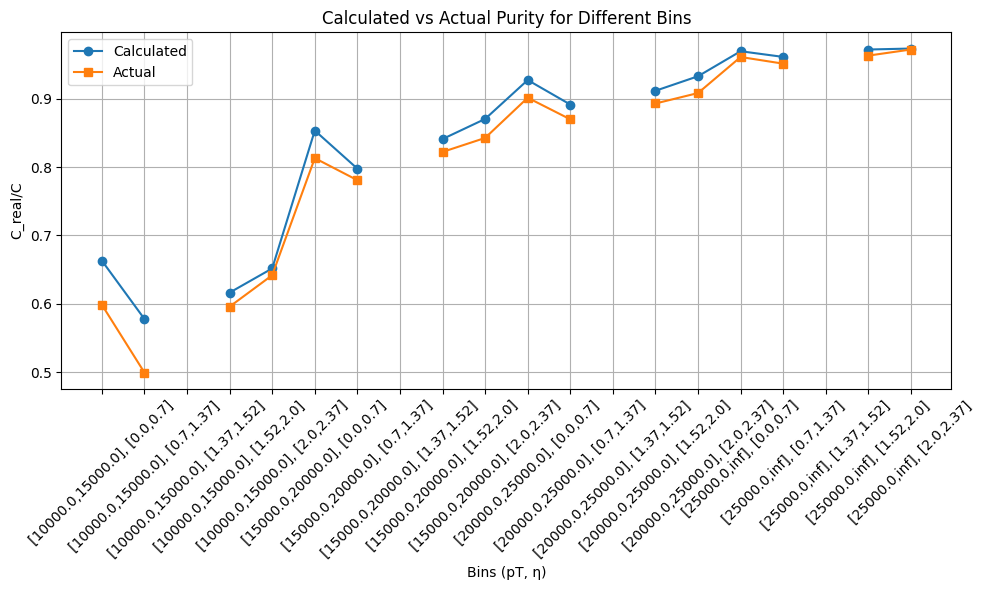

In [14]:
plt.figure(figsize=(10, 6))
plt.plot(bins, calculated_values, label='Calculated', marker='o')
plt.plot(bins, actual_values, label='Actual', marker='s')

plt.title('Calculated vs Actual Purity for Different Bins')
plt.xlabel('Bins (pT, η)')
plt.ylabel('C_real/C')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

/tmp/ipykernel_3941132/3816375696.py:30: RuntimeWarning: invalid value encountered in scalar divide
  C_fake = (A * D) / B
/tmp/ipykernel_3941132/3816375696.py:32: RuntimeWarning: invalid value encountered in scalar divide
  actualRatio = realReal/C


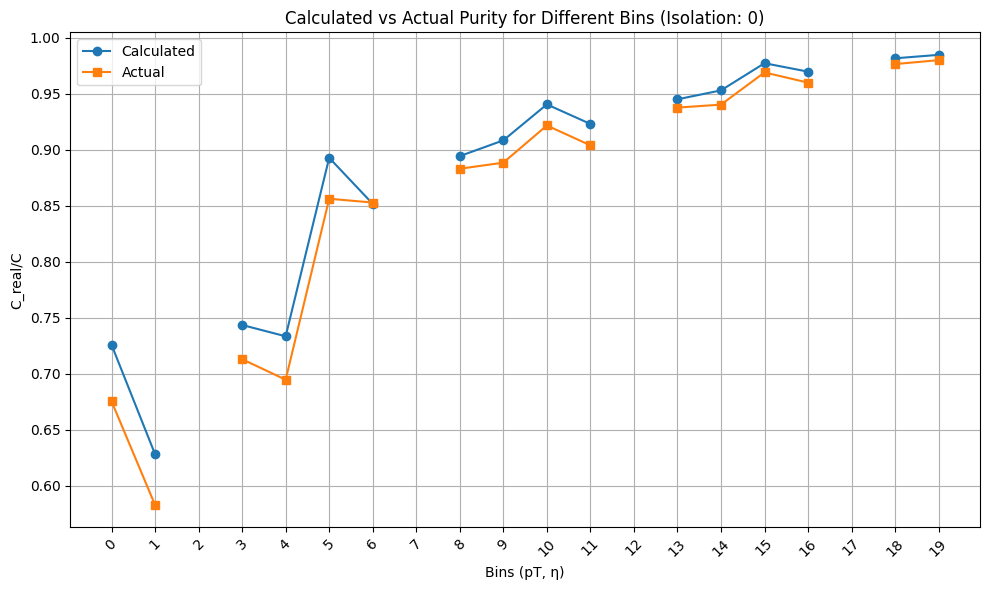

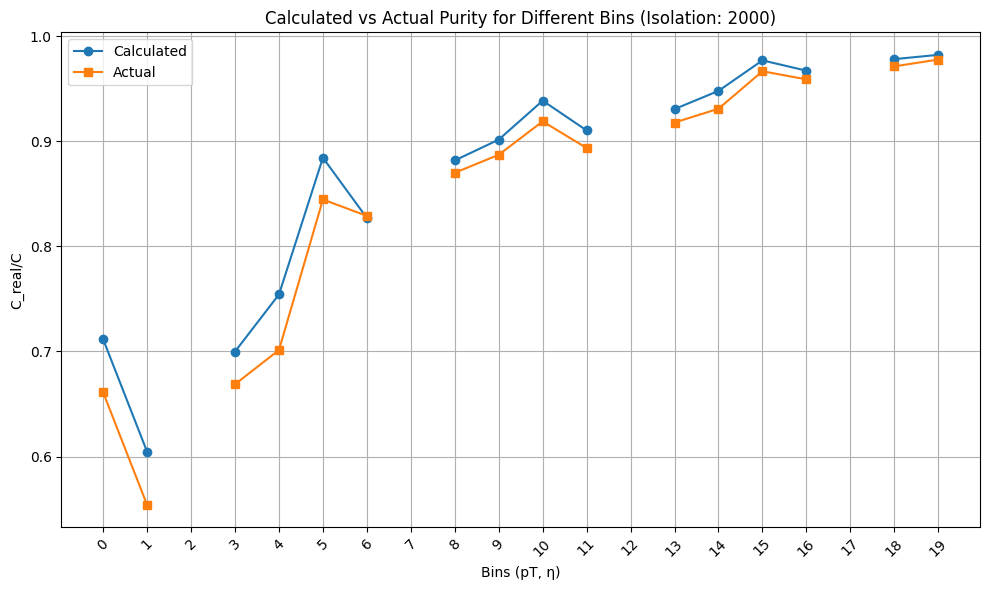

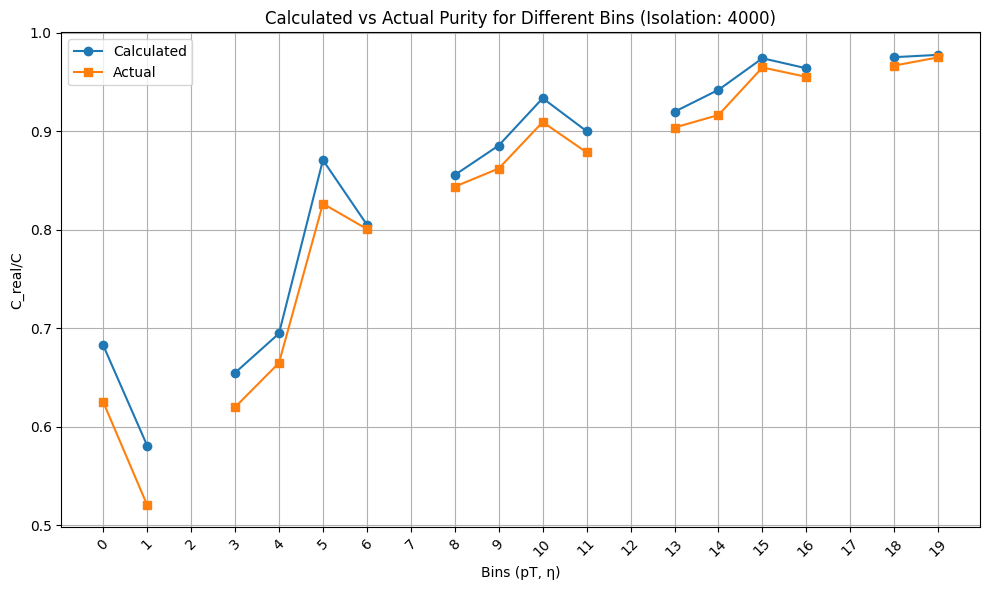

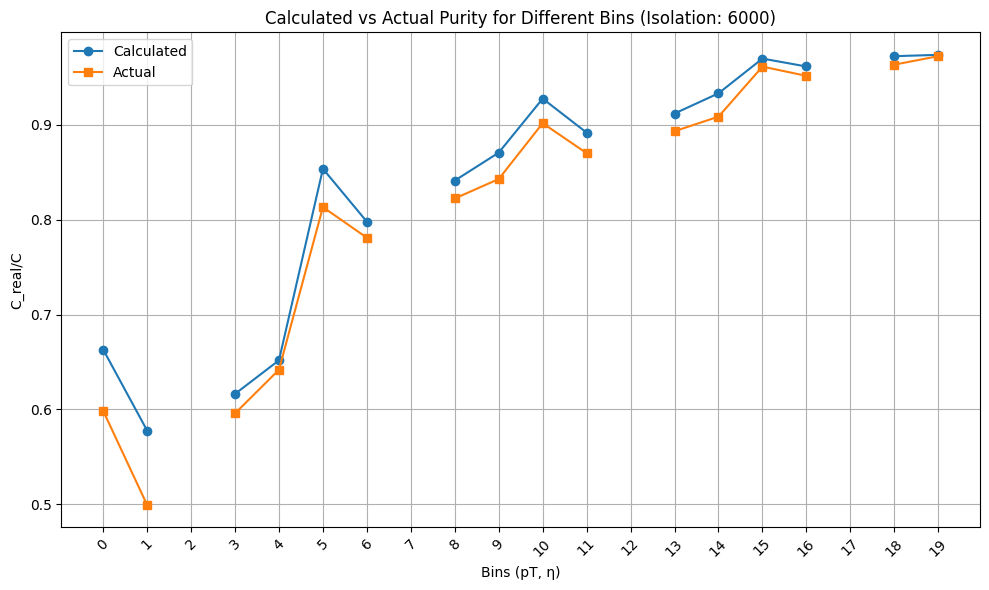

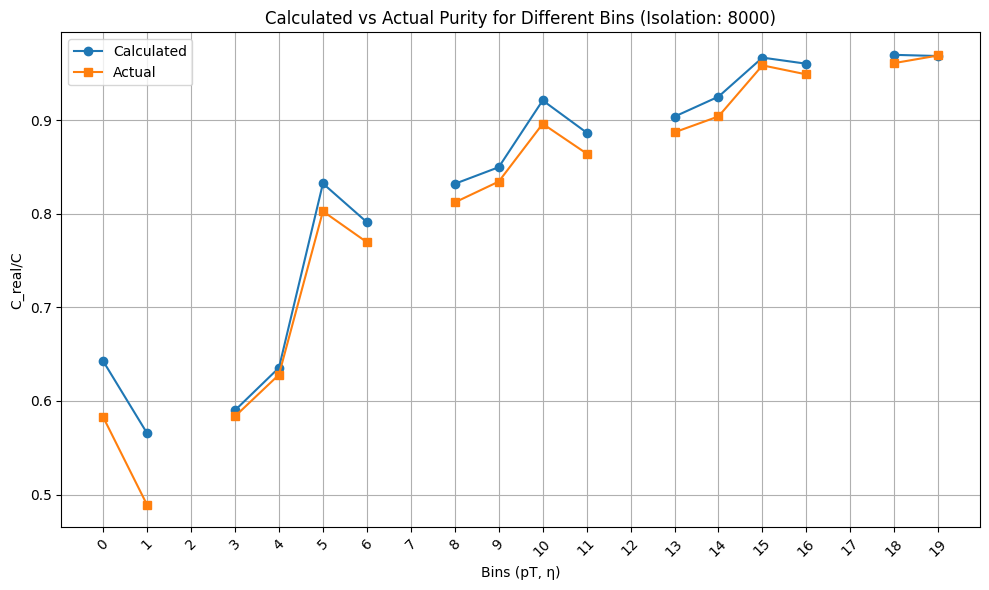

In [40]:

#tightMask = (combined_data['ph.tight_AOD'] == True) 
#notTightMask = (combined_data['ph.tight_AOD'] != True) 
tightMask = (combined_data['ph.isEM_tight_id_incl'] == 0)
notTightMask = ( (combined_data['ph.isEM_tight_id_incl'] & 0x45fc01) == 0 )

isolation_values = [0, 2000, 4000, 6000, 8000]
differences_by_iso = []

for iso_val in isolation_values:
    notIsolatedMask = (combined_data['ph.topoetcone30'] > iso_val)
    isolatedMask = (combined_data['ph.topoetcone30'] < iso_val)
    
    bins = []
    calculated_values = []
    actual_values = []
    differences = [];
    
    for i in range(len(pt_bins) - 1):
        for j in range(len(eta_bins) - 1):
            # Mask for current pt and eta bin
            bin_mask = (pt_indices == i) & (eta_indices == j)
            
            # Calculate A, B, C, D, and other values
            A = np.sum(bin_mask & tightMask & notIsolatedMask & ~realMask) 
            B = np.sum(bin_mask & notTightMask & notIsolatedMask & ~realMask)  
            C = np.sum(bin_mask & tightMask & isolatedMask)
            D = np.sum(bin_mask & notTightMask & isolatedMask & ~realMask) 
            realReal = np.sum(bin_mask & tightMask & isolatedMask & realMask)
                
            C_fake = (A * D) / B
            targetRatio = 1 - (C_fake / C)
            actualRatio = realReal/C
    
            bins.append(f'[{pt_bins[i]:.1e},{pt_bins[i+1]:.1e}], [{eta_bins[j]:.1e},{eta_bins[j+1]:.1e}]')
            calculated_values.append(targetRatio)
            actual_values.append(actualRatio)
            differences.append(targetRatio - actualRatio)

    #print(differences)
    differences_by_iso.append(differences)
    
    # Plot
    plt.figure(figsize=(10, 6))
    plt.plot(bins, calculated_values, label='Calculated', marker='o')
    plt.plot(bins, actual_values, label='Actual', marker='s')
    
    plt.title(f'Calculated vs Actual Purity for Different Bins (Isolation: {iso_val})')
    plt.xlabel('Bins (pT, η)')
    plt.ylabel('C_real/C')
    plt.xticks(rotation=45)
    plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    
    # Show the plot
    plt.show()


plot the difference and have each iso threshhold on once graph

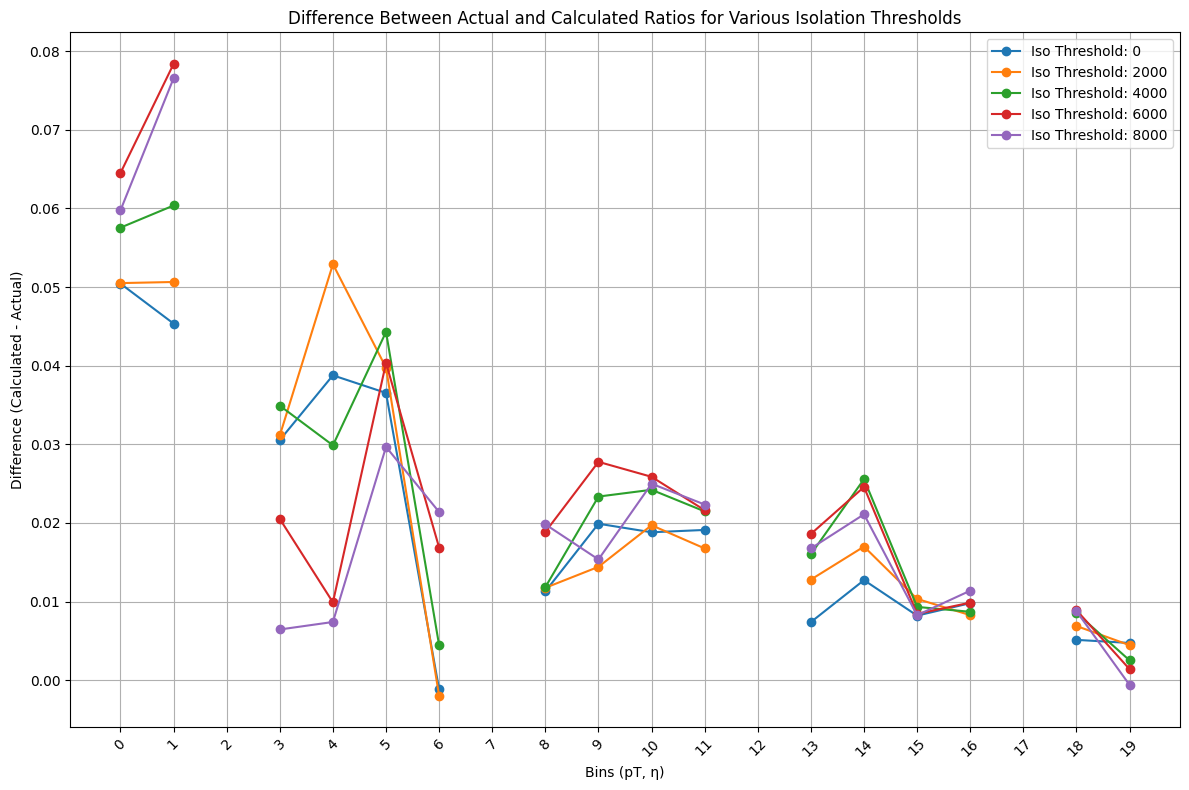

In [41]:
plt.figure(figsize=(12, 8))
for idx, iso_val in enumerate(isolation_values):
    plt.plot(bins, differences_by_iso[idx], marker='o', label=f'Iso Threshold: {iso_val}')

plt.title('Difference Between Actual and Calculated Ratios for Various Isolation Thresholds')
plt.xlabel('Bins (pT, η)')
plt.ylabel('Difference (Calculated - Actual)')
plt.xticks(rotation=45)
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()